# LSTM Model

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import math
import textblob as TextBlob
from textblob import TextBlob
import preprocessor as p

In [75]:
df = pd.read_csv('vader1H_final.csv')
df = df.iloc[: , 1:]
df

,Date,compound,neg,neu,pos,Price
0,2017-10-31 00:00:00,0.111746,0.030924,0.878599,0.088505,6142.46
1,2017-10-31 01:00:00,0.139266,0.026086,0.872914,0.100331,6139.47
2,2017-10-31 02:00:00,0.122860,0.029641,0.872456,0.097270,6128.20
3,2017-10-31 03:00:00,0.114767,0.035427,0.867855,0.096145,6130.72
4,2017-10-31 04:00:00,0.112043,0.038130,0.861398,0.099918,6143.92
...,...,...,...,...,...,...
643,2017-11-26 19:00:00,0.137856,0.034510,0.868098,0.096605,9233.84
644,2017-11-26 20:00:00,0.126233,0.032412,0.875534,0.090744,9304.96
645,2017-11-26 21:00:00,0.144791,0.027903,0.875409,0.095615,9351.25
646,2017-11-26 22:00:00,0.132963,0.031965,0.876167,0.091420,9337.11


## Tiền xử lý dữ liệu

In [76]:
df = df[['Date', 'neg','neu','pos','compound','Price']]

In [77]:
df.columns = ['DateTime','Negative','Neutral','Positive','Compound','Price']
df.head()

,DateTime,Negative,Neutral,Positive,Compound,Price
0,2017-10-31 00:00:00,0.030924,0.878599,0.088505,0.111746,6142.46
1,2017-10-31 01:00:00,0.026086,0.872914,0.100331,0.139266,6139.47
2,2017-10-31 02:00:00,0.029641,0.872456,0.097270,0.122860,6128.20
3,2017-10-31 03:00:00,0.035427,0.867855,0.096145,0.114767,6130.72
4,2017-10-31 04:00:00,0.038130,0.861398,0.099918,0.112043,6143.92


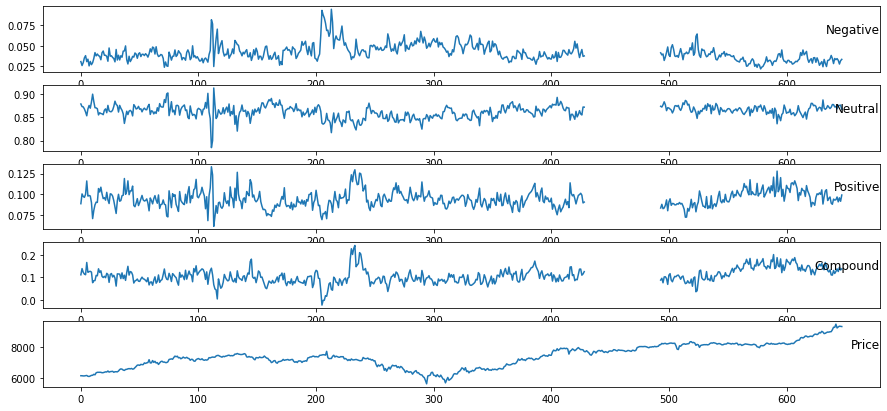

In [78]:
values = df.values
# specify columns to plot
groups = [ 1,2,3,4,5]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [79]:
#Cài đặt cột DateTime làm index
df.set_index('DateTime',inplace=True)

In [80]:
#Chuyển cột Price lên trước
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head()

,Price,Negative,Neutral,Positive,Compound
DateTime,,,,,
2017-10-31 00:00:00,6142.46,0.030924,0.878599,0.088505,0.111746
2017-10-31 01:00:00,6139.47,0.026086,0.872914,0.100331,0.139266
2017-10-31 02:00:00,6128.20,0.029641,0.872456,0.097270,0.122860
2017-10-31 03:00:00,6130.72,0.035427,0.867855,0.096145,0.114767
2017-10-31 04:00:00,6143.92,0.038130,0.861398,0.099918,0.112043


## Xử lý dữ liệu
### Scale
Cột "Price" có giá trị chênh lệch nhau rất lớn nên để tránh khiến cho mô hình bị ảnh hưởng bởi sự khác biệt lớn giữa các dòng dữ liệu, tiến hành chuyển dữ liệu thành giá trị 0-1.

In [81]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

## Xây dựng mô hình
### Thiết lập các giá trị
LSTM sử dụng các giá trị trước của chuỗi thời gian để dự đoán giá trị sau. Ví dụ, với n_hours=3, LSTM sẽ sử dụng các dòng dữ liệu lúc 11h, 12h, 13h để dự đoán cho giá trị lúc 14h cùng ngày; và sử dụng 12h, 13h, 14h để dự đoán cho giá trị lúc 15h hàng ngày.
LSTM có thể học được ngay cả những chuỗi thời gian không dừng (non-stationary), tuy nhiên, nếu kết quả dự đoán không tốt thì việc xử lý chuỗi thành chuỗi dừng nên được cân nhắc. Trong đồ án này, kết quả nhóm đạt được là khá tốt nên nhóm không tiến hành kiểm tra tính dừng.

In [82]:
n_hours = 3
n_features = 5
n_obs = n_hours*n_features

Chuyển các biến thành dạng có chứa thời gian lag. Ở đây nhóm có n_features = 5 (số lượng biến đầu vào, "Price", "Negative", "Positive", "Neutral", "Compound") và n_hours = 3 (như đã giải thích bên trên).

In [83]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Converts the original dataframe to a format which contains
    lag shifted values of inputs which can be used as input
    to the LSTM
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Dataframe sau khi đã scale và chuyển đổi dạng:

In [84]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.135824,0.123032,0.731731,0.380077,0.507855,0.135051,0.056276,0.687452,0.544117,0.612352,0.132134,0.105329,0.683882,0.501663,0.550053,0.132786,0.185157,0.648051,0.486053,0.519325
4,0.135051,0.056276,0.687452,0.544117,0.612352,0.132134,0.105329,0.683882,0.501663,0.550053,0.132786,0.185157,0.648051,0.486053,0.519325,0.136202,0.222462,0.597755,0.538384,0.508982
5,0.132134,0.105329,0.683882,0.501663,0.550053,0.132786,0.185157,0.648051,0.486053,0.519325,0.136202,0.222462,0.597755,0.538384,0.508982,0.140043,0.121847,0.533778,0.761174,0.714718
6,0.132786,0.185157,0.648051,0.486053,0.519325,0.136202,0.222462,0.597755,0.538384,0.508982,0.140043,0.121847,0.533778,0.761174,0.714718,0.126362,0.163295,0.648751,0.507411,0.549500
7,0.136202,0.222462,0.597755,0.538384,0.508982,0.140043,0.121847,0.533778,0.761174,0.714718,0.126362,0.163295,0.648751,0.507411,0.549500,0.123375,0.050610,0.707191,0.517629,0.561803


Với var1 là "Price", tức là **var1(t)** là biến ta cần dự đoán dựa trên các giá trị var(n) trong 3 giờ trước, tức **var(n)(t-1), var(n)(t-2), var(n)(t-3)**. Do đó, ta không sử dụng các biến var(n)(t) nên tiến hành xóa bỏ các cột chứa biến này.

In [85]:
reframed = reframed.drop(reframed.columns[-4:], axis=1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
3,0.135824,0.123032,0.731731,0.380077,0.507855,0.135051,0.056276,0.687452,0.544117,0.612352,0.132134,0.105329,0.683882,0.501663,0.550053,0.132786
4,0.135051,0.056276,0.687452,0.544117,0.612352,0.132134,0.105329,0.683882,0.501663,0.550053,0.132786,0.185157,0.648051,0.486053,0.519325,0.136202
5,0.132134,0.105329,0.683882,0.501663,0.550053,0.132786,0.185157,0.648051,0.486053,0.519325,0.136202,0.222462,0.597755,0.538384,0.508982,0.140043
6,0.132786,0.185157,0.648051,0.486053,0.519325,0.136202,0.222462,0.597755,0.538384,0.508982,0.140043,0.121847,0.533778,0.761174,0.714718,0.126362
7,0.136202,0.222462,0.597755,0.538384,0.508982,0.140043,0.121847,0.533778,0.761174,0.714718,0.126362,0.163295,0.648751,0.507411,0.549500,0.123375


### Chia train test
170 giờ đầu tiên được sử dụng để train, và thời gian còn lại dùng để test

In [86]:
values = reframed.values
n_train_hours = 170
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(170, 16)

In [87]:
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [88]:
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(170, 3, 5) (170,) (408, 3, 5) (408,)


Có thể giải thích shape của các vector như sau:
- trainX (170, 3, 5): 170 dòng, 3 giờ, 5 thuộc tính
- train_y (170,): 170 dòng
- test_X (408, 3, 5): 408 dòng, 3 giờ, 5 thuộc tính
- test_y (408,): 408 dòng

### Xây dựng mô hình mạng LSTM

In [89]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

Epoch 1/20
43/43 - 2s - loss: 0.1133 - val_loss: 0.1270 - 2s/epoch - 49ms/step
Epoch 2/20
43/43 - 0s - loss: 0.0782 - val_loss: 0.1160 - 247ms/epoch - 6ms/step
Epoch 3/20
43/43 - 0s - loss: 0.0786 - val_loss: 0.1138 - 244ms/epoch - 6ms/step
Epoch 4/20
43/43 - 0s - loss: 0.0763 - val_loss: 0.1107 - 295ms/epoch - 7ms/step
Epoch 5/20
43/43 - 0s - loss: 0.0738 - val_loss: 0.1067 - 246ms/epoch - 6ms/step
Epoch 6/20
43/43 - 0s - loss: 0.0707 - val_loss: 0.1015 - 244ms/epoch - 6ms/step
Epoch 7/20
43/43 - 0s - loss: 0.0662 - val_loss: 0.0952 - 257ms/epoch - 6ms/step
Epoch 8/20
43/43 - 0s - loss: 0.0623 - val_loss: 0.0888 - 260ms/epoch - 6ms/step
Epoch 9/20
43/43 - 0s - loss: 0.0581 - val_loss: 0.0822 - 288ms/epoch - 7ms/step
Epoch 10/20
43/43 - 0s - loss: 0.0544 - val_loss: 0.0758 - 296ms/epoch - 7ms/step
Epoch 11/20
43/43 - 0s - loss: 0.0512 - val_loss: 0.0707 - 273ms/epoch - 6ms/step
Epoch 12/20
43/43 - 0s - loss: 0.0489 - val_loss: 0.0652 - 239ms/epoch - 6ms/step
Epoch 13/20
43/43 - 0s - lo

Giá trị loss không có thay đổi đáng kể từ khoảng epoch 18

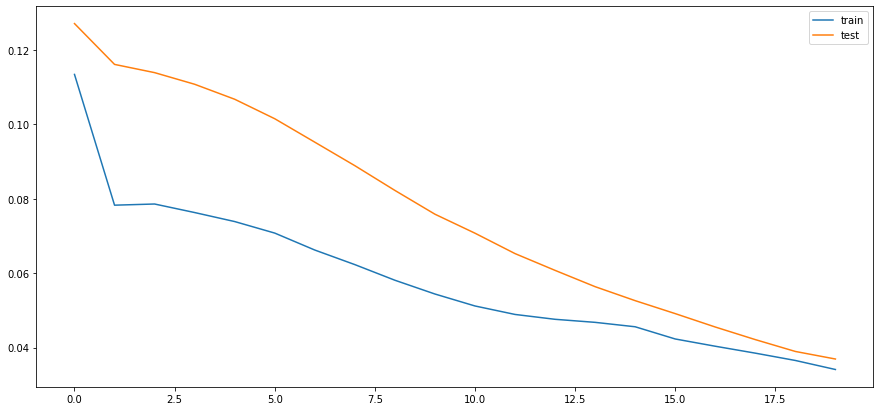

In [90]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [91]:
from sklearn.metrics import mean_squared_error

# Dự đoán
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# Scale các giá trị dự đoán
inv_yhat = np.concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# Chuyển giá trị dự đoán về lại dạng số bình thường
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

13/13 [==============================] - 0s 2ms/step
Test RMSE: 196.661


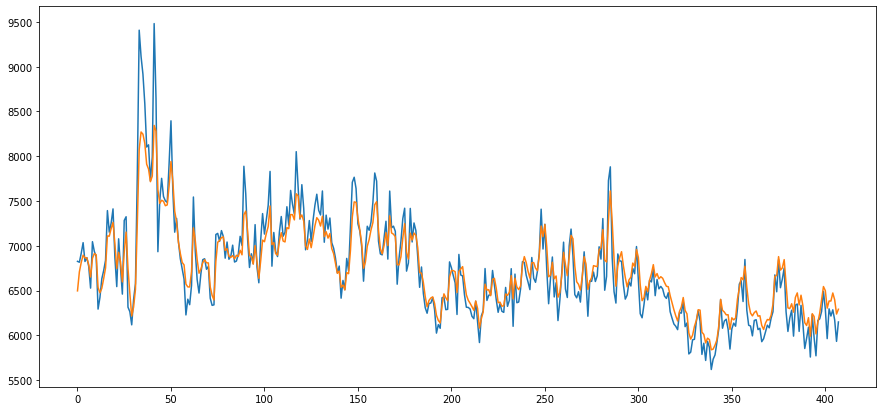

In [92]:
plt.plot(inv_y)
plt.plot(inv_yhat)

In [60]:
plt.show()

In [93]:
df_sol = pd.DataFrame({'forecast':inv_yhat,'actual':inv_y})
df_sol.to_csv('Predictions_nosent_final.csv')